In [3]:
import numpy as np
from brian2 import *
from random import randrange
from collections import Counter
import math

In [4]:
def pulse_input_current_generator(max_I,delta_time,duration,possibility):
    output = TimedArray([np.random.choice([max_I,0],p=[possibility,1 - possibility]) * namp for i in range(int(duration/delta_time))],delta_time)
    return output

In [5]:
def simulate(duration = 100 * ms , Resistance_1 = 4 * Mohm , Resistance_2 = 5 * Mohm , I_1 = 14 , I_2 = 9 , initial_w = 0.5 , Apre = 0.1,
            p_1 = 0.5 , p_2 = 0.3 , tau_1 = 6*ms , tau_2 = 8*ms , 
             u_rest_1 = -72 * mV , u_rest_2 = -68 * mV , threshold_1 = -54 * mV , threshold_2 = -55 * mV):
    
    start_scope()
    delta_time = 1 * ms
    wmax = 1
    Apost = -Apre * tau_1 / tau_2 * 1.04
    
    input_current_1 = pulse_input_current_generator(I_1 , delta_time , duration , p_1)
    input_current_2 = pulse_input_current_generator(I_2 , delta_time , duration , p_2)
    
    eqs_1 = '''
        du/dt = -(u-u_rest_1)/tau + Resistance_1 * input_current_1(t)/tau : volt
        tau : second
    '''
    neuron_1 = NeuronGroup(1,eqs_1,threshold='u>threshold_1', reset='u=u_rest_1',method='linear')
    neuron_1.u = u_rest_1
    neuron_1.tau = tau_1
    
    eqs_2 = '''
        du/dt = -(u-u_rest_2)/tau + Resistance_2 * input_current_2(t)/tau : volt
        tau : second
    '''
    neuron_2 = NeuronGroup(1,eqs_2,threshold='u>threshold_2', reset='u=u_rest_2',method='linear')
    neuron_2.u = u_rest_2
    neuron_2.tau = tau_2
    
    syn = Synapses(neuron_1 , neuron_2 ,'''
             w : 1
             dapre/dt = -apre/tau_1 : 1 (clock-driven)
             dapost/dt = -apost/tau_2 : 1 (clock-driven)
             ''' ,
             on_pre= '''
             u_post += w * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn.connect(i=0 , j=0)
    syn.w = initial_w
    
    
    M = StateMonitor(syn, ['w', 'apre', 'apost'], record=True)
    s1 = SpikeMonitor(neuron_1)
    s2 = SpikeMonitor(neuron_2)
    
    run(duration)
    
    pre = [x/ms for x in list(s1.all_values()['t'][0])]
    post = [x/ms for x in list(s2.all_values()['t'][0])]
    wlist = M.w[0]
    
    x = []
    y = []

    for i in pre:
        to_check = []
        for j in post:
            if j<i:
                to_check.append(j)
        if len(to_check) == 0:
            continue
        else:
            x.append(i - max(to_check))
            y.append(wlist[int(i*10)+1] - wlist[int(i*10)])
            
    for i in post:
        to_check = []
        for j in pre:
            if j<i:
                to_check.append(j)
        if len(to_check) == 0:
            continue
        else:
            x.append(max(to_check) - i)
            y.append(wlist[int(i*10)+1] - wlist[int(i*10)])
        

        
    fig = plt.figure(figsize=(8, 8) , constrained_layout=True)
    gs = fig.add_gridspec(3, 4)
    axs0 = fig.add_subplot(gs[0, :])
    axs1 = fig.add_subplot(gs[1, :])
    axs2 = fig.add_subplot(gs[2, :])

    axs0.plot(M.t/ms, M.apre[0], label='apre')
    axs0.plot(M.t/ms, M.apost[0], label='apost')
    axs0.axhline(color='red')
    axs0.legend()
    
    axs1.plot(M.t/ms, M.w[0], label='w')
    legend(loc='best')
    xlabel('Time (ms)')
    ylabel('W (mV)')
    
    axs2.scatter(x,y)
    xlabel('Delta Time (ms)')
    ylabel('Delta W (mV)')
    return
    
    

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.48s). [brian2.stateupdaters.base.method_choice]
No handles with labels found to put in legend.


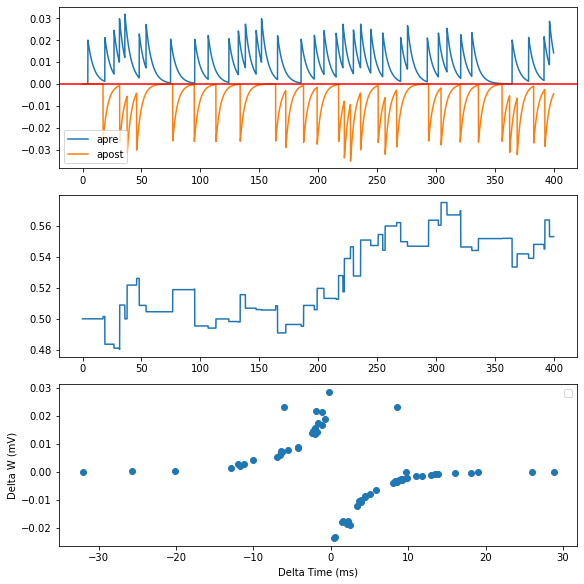

In [6]:
simulate(duration = 400*ms , Resistance_1 = 3 * Mohm , Resistance_2 = 2 * Mohm , I_1 = 10 , I_2 = 9 , initial_w = 0.5 , Apre = 0.02,
            p_1 = 0.6 , p_2 = 0.6 , tau_1 = 5*ms , tau_2 = 4*ms , 
             u_rest_1 = -72 * mV , u_rest_2 = -68 * mV , threshold_1 = -54 * mV , threshold_2 = -55 * mV)

No handles with labels found to put in legend.


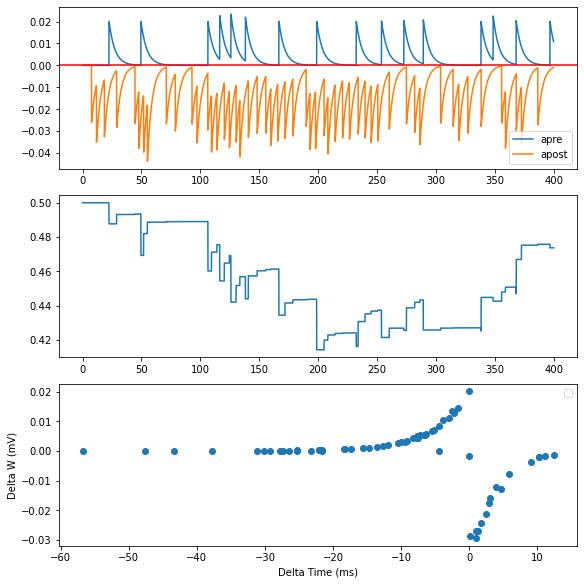

In [7]:
simulate(duration = 400*ms , Resistance_1 = 6 * Mohm , Resistance_2 = 4 * Mohm , I_1 = 4 , I_2 = 6 , initial_w = 0.5 , Apre = 0.02,
            p_1 = 0.6 , p_2 = 0.6 , tau_1 = 5*ms , tau_2 = 4*ms , 
             u_rest_1 = -72 * mV , u_rest_2 = -68 * mV , threshold_1 = -54 * mV , threshold_2 = -55 * mV)

INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.25s). [brian2.stateupdaters.base.method_choice]
No handles with labels found to put in legend.


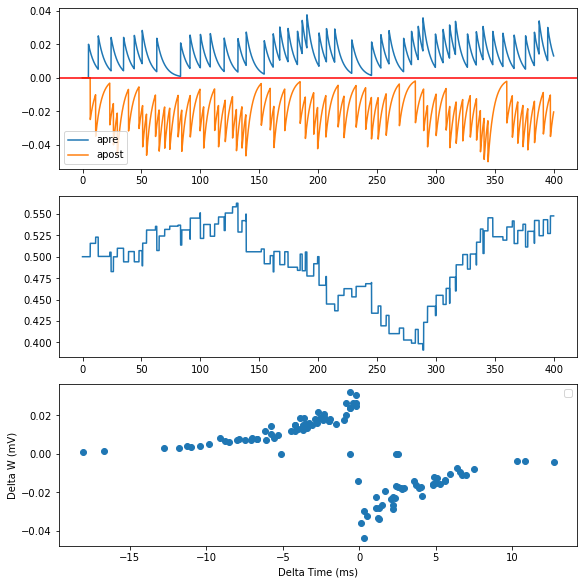

In [8]:
simulate(duration = 400*ms , Resistance_1 = 8 * Mohm , Resistance_2 = 3 * Mohm , I_1 = 6 , I_2 = 7 , initial_w = 0.5 , Apre = 0.02,
            p_1 = 0.6 , p_2 = 0.6 , tau_1 = 6*ms , tau_2 = 5*ms , 
             u_rest_1 = -77 * mV , u_rest_2 = -65 * mV , threshold_1 = -54 * mV , threshold_2 = -55 * mV)

INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.24s). [brian2.stateupdaters.base.method_choice]
No handles with labels found to put in legend.


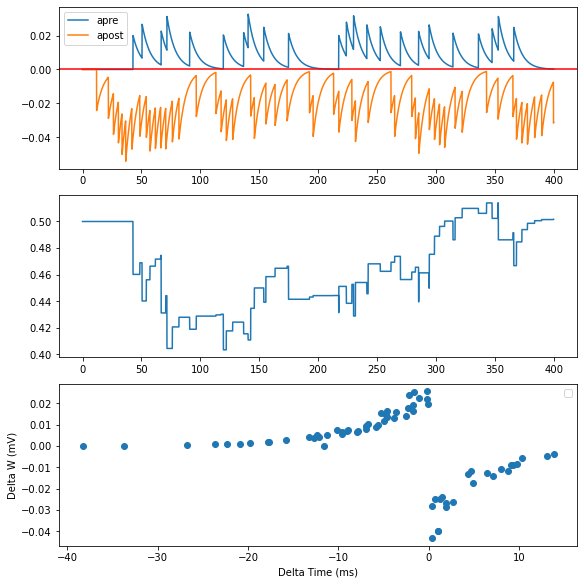

In [9]:
simulate(duration = 400*ms , Resistance_1 = 7 * Mohm , Resistance_2 = 5 * Mohm , I_1 = 8 , I_2 = 5 , initial_w = 0.5 , Apre = 0.02,
            p_1 = 0.4 , p_2 = 0.5 , tau_1 = 7*ms , tau_2 = 6*ms , 
             u_rest_1 = -77 * mV , u_rest_2 = -65 * mV , threshold_1 = -54 * mV , threshold_2 = -55 * mV)